# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [33]:
## basic functionality
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
from plotnine import *
warnings.filterwarnings('ignore')

import nbconvert

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [2]:
current_directory = os.getcwd()

df = sentencing_df = pd.read_csv("sentencing_asof0405.csv")

## 0.2: Print head, dimensions, info (0 points)

In [3]:
df.head()
df.shape
df.info()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50510112469,116304211997,FIRST DEGREE MURDER,2,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
1,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50510213021,98265074680,HOME INVASION,14,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
2,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516447217,131972895911,FIRST DEGREE MURDER,4,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
3,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516497493,131966356472,FIRST DEGREE MURDER,5,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide
4,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,False,50516648320,98059642859,HOME INVASION,13,12/17/2014 12:00:00 AM,...,NaN,8/9/1984 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,8/15/1984 12:00:00 AM,08/15/1984 12:00:00 AM,Charge(S) Approved,9/21/1984 12:00:00 AM,Homicide


(248146, 41)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248146 entries, 0 to 248145
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   CASE_ID                            248146 non-null  int64  
 1   CASE_PARTICIPANT_ID                248146 non-null  int64  
 2   RECEIVED_DATE                      248146 non-null  object 
 3   OFFENSE_CATEGORY                   248146 non-null  object 
 4   PRIMARY_CHARGE_FLAG                248146 non-null  bool   
 5   CHARGE_ID                          248146 non-null  int64  
 6   CHARGE_VERSION_ID                  248146 non-null  int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  248146 non-null  object 
 8   CHARGE_COUNT                       248146 non-null  int64  
 9   DISPOSITION_DATE                   248146 non-null  object 
 10  DISPOSITION_CHARGED_CHAPTER        248146 non-null  object 
 11  DISPOSITION_CHARGED_ACT            2427

# Part one: data cleaning/interpretation


## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
    - Why there are more unique charges than unique people?

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.


In [4]:
df[["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID"]].nunique()

CASE_ID                197519
CASE_PARTICIPANT_ID    211977
CHARGE_ID              229015
dtype: int64

In [5]:
# There are more unique people than unique cases because some cases involve multiple people.

# Example:

# Build list of numbers of participant IDs per cases
case_counts = df.groupby("CASE_ID")["CASE_PARTICIPANT_ID"].nunique()

# Filter for cases with more than one distinct 'CASE_PARTICIPANT_ID'
cases_with_multiple_participants = case_counts[case_counts > 1].index

# Print the CASE_ID values that match multiple CASE_PARTICIPANT_ID values
print(cases_with_multiple_participants)


Index([166402790922, 176098576921, 176270837451, 180953886081, 181880245351,
       193220363111, 193669004134, 193935251654, 196479655698, 202800868193,
       ...
       442469161188, 442469748607, 442472832555, 442477531905, 442479441015,
       442924851235, 443338247136, 443405066012, 443440604843, 443593921120],
      dtype='int64', name='CASE_ID', length=12288)


In [6]:
# There are more unique charges than unique people because some people have multiple charges within cases.

# Example:

# Build list of numbers of participant IDs per cases
charge_id_counts = df.groupby("CASE_PARTICIPANT_ID")["CHARGE_ID"].nunique()

# Filter for cases with more than one distinct 'CASE_PARTICIPANT_ID'
participants_with_multiple_charges = charge_id_counts[charge_id_counts > 1].index

print(participants_with_multiple_charges)


Index([ 97581722610,  97603050731, 102758793737, 113431347854, 117303251208,
       119126050596, 125384910456, 128175025077, 128529109638, 129498029199,
       ...
       899219260504, 900047942949, 900135992229, 900210074420, 900745825500,
       901692945079, 901899525864, 904336027784, 904972002160, 905015885242],
      dtype='int64', name='CASE_PARTICIPANT_ID', length=14547)


In [7]:
# Print the mean and median number of charges per case/participant

df.groupby(["CASE_ID", "CASE_PARTICIPANT_ID"])["CHARGE_ID"].count().agg(["mean", "median"])

# Print the mean and median number of participants per case

df.groupby(["CASE_ID"])["CASE_PARTICIPANT_ID"].count().agg(['mean', 'median'])

mean      1.170627
median    1.000000
Name: CHARGE_ID, dtype: float64

mean      1.256315
median    1.000000
Name: CASE_PARTICIPANT_ID, dtype: float64

In [8]:
# Does the data seem to enable us to follow the same defendant across different cases they're charged in? 

no_dups = df[["CASE_PARTICIPANT_ID","CASE_ID"]].drop_duplicates()
no_dups.groupby(["CASE_PARTICIPANT_ID"]).agg({"CASE_ID": "count"}).sort_values(by="CASE_ID", ascending= False)

# No as the above code shows, Case Participant IDs are unique to their associated case. 
# If someone commits a crime but in a different case, they will have an entirely different case ID.

,CASE_ID
CASE_PARTICIPANT_ID,
96757475659,1
811339945611,1
811332962067,1
811333245184,1
811333433928,1
...,...
751606861577,1
751611013954,1
751611485815,1


## 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY` 

- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be

In [9]:
# OFFENSE_CATEGORY represents the general offense category prior to specific charges being filed, 
# while UPDATED_OFFENSE_CATEGORY reflects the updated offense category determined by the primary charge in the case.

In [10]:
# Construct an indicator is_changed_offense

df["is_changed_offense"] = df["OFFENSE_CATEGORY"]!= df["UPDATED_OFFENSE_CATEGORY"]

In [11]:
# more common changed offenses

df[df["is_changed_offense"]]["OFFENSE_CATEGORY"].value_counts().sort_values(ascending = False)



OFFENSE_CATEGORY
PROMIS Conversion               6394
DUI                             3896
UUW - Unlawful Use of Weapon    2155
Other Offense                   2125
Aggravated Battery              1927
                                ... 
Perjury                            4
Prostitution                       3
Compelling Gang Membership         2
Benefit Recipient Fraud            2
Violate Bail Bond                  2
Name: count, Length: 88, dtype: int64

In [12]:
# Print one example of a changed offense from one of these categories and comment on what the reason may be

example_changed_offense = df[df["is_changed_offense"]].iloc[0]
example_changed_offense

# It seems that PROMIS Conversion means that the court promises to adjust the charge eventully which 
# explains why this Offense is the most frequently changed. 


CASE_ID                                        149765331439
CASE_PARTICIPANT_ID                            175691153649
RECEIVED_DATE                         8/15/1984 12:00:00 AM
OFFENSE_CATEGORY                          PROMIS Conversion
PRIMARY_CHARGE_FLAG                                   False
CHARGE_ID                                       50510112469
CHARGE_VERSION_ID                              116304211997
DISPOSITION_CHARGED_OFFENSE_TITLE       FIRST DEGREE MURDER
CHARGE_COUNT                                              2
DISPOSITION_DATE                     12/17/2014 12:00:00 AM
DISPOSITION_CHARGED_CHAPTER                              38
DISPOSITION_CHARGED_ACT                                   -
DISPOSITION_CHARGED_SECTION                       9-1(a)(2)
DISPOSITION_CHARGED_CLASS                                 X
DISPOSITION_CHARGED_AOIC                         0000001607
CHARGE_DISPOSITION                          Nolle On Remand
CHARGE_DISPOSITION_REASON               

## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [13]:
# combine all offenses beginning with "Aggravated" into a single category
df["simplified_offense_derived"] = df["UPDATED_OFFENSE_CATEGORY"].str.removeprefix("Aggravated ")

# Define conditions
conditions = [
    df['UPDATED_OFFENSE_CATEGORY'].str.contains("arson", case=False),
    df['UPDATED_OFFENSE_CATEGORY'].str.contains("homicide", case=False),
    df['UPDATED_OFFENSE_CATEGORY'].str.contains("vehicle", case=False),
    df['UPDATED_OFFENSE_CATEGORY'].str.contains("vehicular", case=False),
    df['UPDATED_OFFENSE_CATEGORY'].str.contains("battery", case=False)
]

# Define corresponding choices
choices = [
    "Arson",
    "Homicide",
    "Vehicle-related",
    "Vehicle-related",
    "Battery"
]

# Use np.select
df["OFFENSE_CATEGORY"] = np.select(conditions, choices, default=df["OFFENSE_CATEGORY"])


In [14]:
# difference 

df.UPDATED_OFFENSE_CATEGORY.nunique()-df.simplified_offense_derived.nunique()

4

## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [15]:
# Race

dervied_black = ["Black", "White/Black [Hispanic or Latino]"]
df["is_black_derived"] = df["RACE"].isin(dervied_black)

derived_hisp = ["White [Hispanic or Latino]", "HISPANIC"]
df["is_hisp_derived"] = df["RACE"].isin(derived_hisp)

derived_white = ["White"]
df["is_white_derived"] = df["RACE"].isin(derived_white)

derived_other = ["ASIAN", "Asian", "American Indian", "Unknown", "Biracial"]
df["is_othereth_derived"] = df["RACE"].isin(derived_other)

In [16]:
# Gender

male_derived = ["Male", "Male name, no gender given"]
df["is_male_derived"] = df["RACE"].isin(male_derived)


In [17]:
# Age

limit = df["AGE_AT_INCIDENT"].quantile(0.9999)
df["age_derived"] = df["AGE_AT_INCIDENT"].apply(lambda x: min(x, limit))

In [18]:
# Create sentenceymd_derived

df["sentenceymd_derived"] = 0
for i in range(len(df.SENTENCE_DATE)):
    dateSplit = df.SENTENCE_DATE[i].split("/")
    year = dateSplit[2][:4]
    if (year[0] == "2" and year[1] != "0"):
        year = "20" + year[2:]
    dateSplit = dateSplit[0] + "/1/" + year
    df.sentenceymd_derived[i] = dateSplit
df["sentenceymd_derived"] = pd.to_datetime(df.sentenceymd_derived)


In [19]:
# Sentencing judge adjustments

#"Douglas J Simpson" -> "Doug  Simpson"
#"Shelley  Sutker-Dermer" -> "Shelley  Sutker"

judge_list = df["SENTENCE_JUDGE"].sort_values().unique().tolist()

judge_list.remove("Douglas J Simpson")
judge_list.remove("Shelley  Sutker-Dermer")

judge_number = ['judge_{}'.format(i) for i in range(1, len(judge_list))]

judge_list.append("Douglas J Simpson")
judge_number.append(judge_list.index("Doug  Simpson"))
judge_list.append("Shelley  Sutker-Dermer")
judge_number.append(judge_list.index("Shelley  Sutker"))

conversion_dict = dict(zip(judge_list,judge_number))
df["judgeid_derived"] = df.SENTENCE_JUDGE.map(conversion_dict)


df[["RACE", "is_black_derived", "is_hisp_derived", "is_white_derived", "is_othereth_derived", 
    "GENDER", "is_male_derived", "AGE_AT_INCIDENT", "age_derived", "SENTENCE_DATE", "sentenceymd_derived",
   "SENTENCE_JUDGE", "judgeid_derived"]].sample(n=10)

,RACE,is_black_derived,is_hisp_derived,is_white_derived,is_othereth_derived,GENDER,is_male_derived,AGE_AT_INCIDENT,age_derived,SENTENCE_DATE,sentenceymd_derived,SENTENCE_JUDGE,judgeid_derived
31470,Black,True,False,False,False,Male,False,25.0,25.0,9/20/2012 12:00:00 AM,2012-09-01,NaN,70
103171,Black,True,False,False,False,Male,False,20.0,20.0,9/26/2013 12:00:00 AM,2013-09-01,Domenica A Stephenson,judge_63
200238,White [Hispanic or Latino],False,True,False,False,Male,False,21.0,21.0,5/3/2017 12:00:00 AM,2017-05-01,James N Karahalios,judge_117
203256,Black,True,False,False,False,Male,False,30.0,30.0,5/21/2018 12:00:00 AM,2018-05-01,William Raines,judge_325
84609,Black,True,False,False,False,Male,False,24.0,24.0,6/30/2015 12:00:00 AM,2015-06-01,Maura Slattery Boyle,judge_212
53121,Black,True,False,False,False,Female,False,44.0,44.0,1/5/2012 12:00:00 AM,2012-01-01,Maura Slattery Boyle,judge_212
203225,Black,True,False,False,False,Female,False,45.0,45.0,6/12/2017 12:00:00 AM,2017-06-01,Vincent M Gaughan,judge_321
228726,Black,True,False,False,False,Male,False,23.0,23.0,7/8/2019 12:00:00 AM,2019-07-01,Timothy Joseph Joyce,judge_315
80990,Black,True,False,False,False,Male,False,27.0,27.0,7/8/2013 12:00:00 AM,2013-07-01,Shelley Sutker-Dermer,NaN
98100,Black,True,False,False,False,Male,False,31.0,31.0,8/26/2014 12:00:00 AM,2014-08-01,James B Linn,judge_110


## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [21]:
# Subset 

df_cases_cc_one = df[df["CHARGE_COUNT"] == 1]

# participant-level dataset

participant_level_df = df_cases_cc_one[(df_cases_cc_one["PRIMARY_CHARGE_FLAG"]== True) & (df_cases_cc_one["CURRENT_SENTENCE_FLAG"]== True)]

# Check

participant_level_df.groupby(["CASE_ID", "CASE_PARTICIPANT_ID"])["CHARGE_ID"].value_counts().nunique()

# Filter out observations where judge is nan or nonsensical

participant_level_df_judge_adj = participant_level_df[(participant_level_df["SENTENCE_JUDGE"].notna()) & (participant_level_df["SENTENCE_JUDGE"] != "FLOOD")]

# Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

date_sub_df = participant_level_df_judge_adj[(participant_level_df_judge_adj["sentenceymd_derived"] >= "2012-01-01") & 
                                             (participant_level_df_judge_adj["sentenceymd_derived"] <= "2021-04-05")]

# print the number of rows in the data

print(len(date_sub_df))

1

149617


# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [22]:
df_clean = sentencing_cleaned_df = pd.read_pickle("sentencing_cleaned.pkl")

# 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

In [23]:
# Clean and convert dates for grouping

df_clean["SENTENCE_DATE"] = df_clean["SENTENCE_DATE"].str.replace(" 12:00:00 AM", "")

df_clean["SENTENCE_DATE_dt"] = pd.to_datetime(df_clean["SENTENCE_DATE"], errors = "coerce")

df_clean["MONTH"] = df_clean["SENTENCE_DATE_dt"].dt.month
df_clean["YEAR"] = df_clean["SENTENCE_DATE_dt"].dt.year

df_clean["MONTH_YEAR_1"] = pd.to_datetime(df_clean[["YEAR", "MONTH"]].assign(day=1))

In [24]:
# create denominators and numerators

den = df_clean.groupby("MONTH_YEAR_1")["CASE_ID"].nunique()

num_black = df_clean.groupby("MONTH_YEAR_1")["is_black_derived"].sum()

num_white = df_clean.groupby("MONTH_YEAR_1")["is_white_derived"].sum()

# fractions

result_table = pd.concat([den, num_black/den, num_white/den], axis=1)
result_table.columns = ["Monthly Case Count", "Proportion Black Derived", "Proportion White Derived"]

result_table_lim = result_table[result_table.index<"2022-01-01"]

# Print the table
result_table_lim


,Monthly Case Count,Proportion Black Derived,Proportion White Derived
MONTH_YEAR_1,,,
2012-01-01,1674,0.677419,0.144564
2012-02-01,1450,0.648966,0.160690
2012-03-01,1612,0.638958,0.158189
2012-04-01,1436,0.696379,0.146936
2012-05-01,1545,0.695146,0.144337
...,...,...,...
2020-11-01,491,0.606925,0.154786
2020-12-01,537,0.646182,0.158287
2021-01-01,447,0.621924,0.111857


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Proportion of Total Defendants')

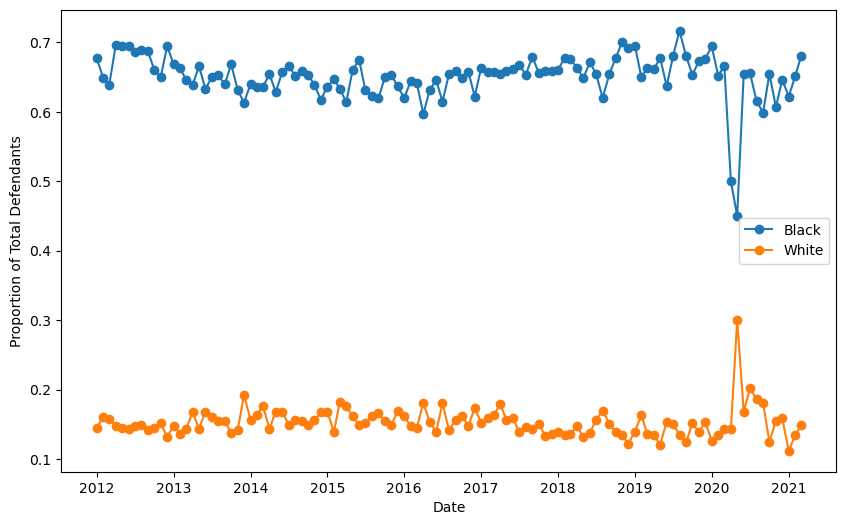

In [25]:
# build plot
plt.figure(figsize=(10, 6))
plt.plot(result_table_lim.index, result_table_lim["Proportion Black Derived"], label="Black", marker="o")
plt.plot(result_table_lim.index, result_table_lim["Proportion White Derived"], label="White", marker="o")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Proportion of Total Defendants")
plt.legend(["Black", "White"])

# Show the plot
plt.show()



$$
\text{Incarceration Propotion by Race}=\frac{1}{N}\sum_{i=1}^{n} B_i
$$

$$B_i \text{  represents the number of Black or White Defendants Incarcerated for Date \(i\).}$$

Covid caused unusual changed in patterns of incarceraction. In this case the start of the pandemic was correlated with a drop in Black incareration and rise in white incarcerations. 




## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

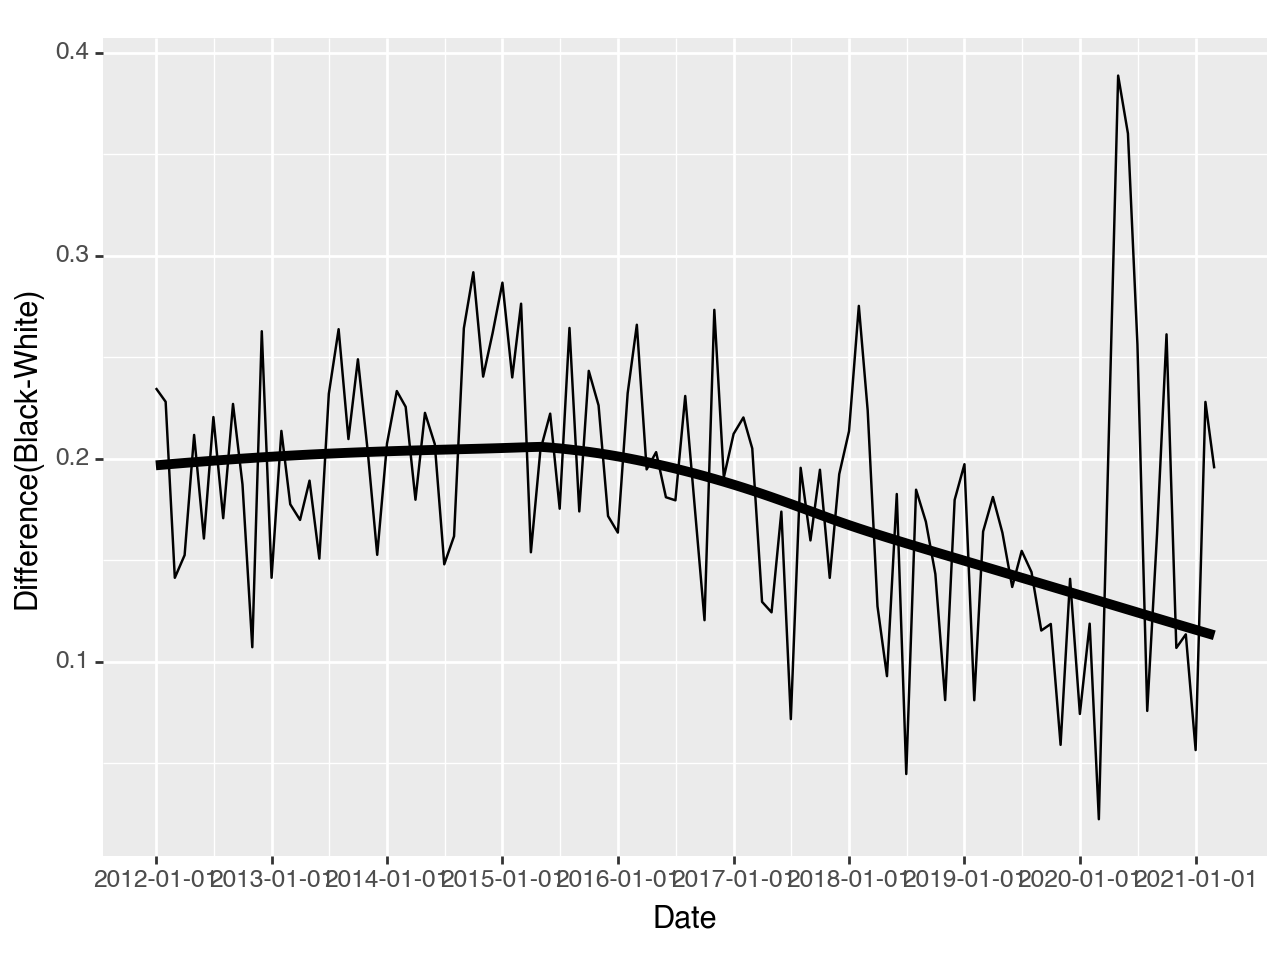

<Figure Size: (640 x 480)>

In [26]:
# demoninators 
black_total_den = df_clean[df_clean["is_black_derived"] == True].groupby("MONTH_YEAR_1")["CASE_ID"].nunique()
#black_total_den
white_total_den = df_clean[df_clean["is_white_derived"] == True].groupby("MONTH_YEAR_1")["CASE_ID"].nunique()
#white_total_den

# numerators
filtered_df_clean_black = df_clean[(df_clean["COMMITMENT_TYPE"] == "Illinois Department of Corrections") & (df_clean["is_black_derived"] == True)]
black_incar_df = filtered_df_clean_black.groupby("MONTH_YEAR_1").size().reset_index(name="Black Defendants Incarcerated")


filtered_df_clean_white = df_clean[(df_clean["COMMITMENT_TYPE"] == "Illinois Department of Corrections") & (df_clean["is_white_derived"] == True)]
white_incar_df = filtered_df_clean_white.groupby("MONTH_YEAR_1").size().reset_index(name="White Defendants Incarcerated")

# build dataframe
combo_df = pd.merge(black_incar_df, black_total_den, on="MONTH_YEAR_1", how="left")
combo_df = pd.merge(combo_df, white_incar_df, on="MONTH_YEAR_1", how="left")
combo_df = pd.merge(combo_df, white_total_den, on="MONTH_YEAR_1", how="left")



# create proportions
combo_df["Black Incarceration Ratio"] = combo_df["Black Defendants Incarcerated"] / combo_df["CASE_ID_x"]
combo_df["White Incarceration Ratio"] = combo_df["White Defendants Incarcerated"] / combo_df["CASE_ID_y"]

# calculate difference
combo_df["Difference"] = combo_df["Black Incarceration Ratio"] - combo_df["White Incarceration Ratio"]

combo_df_cut = combo_df[combo_df["MONTH_YEAR_1"] < "2022-01-01"]

ggplot(data=combo_df_cut, mapping=aes(x="MONTH_YEAR_1", y="Difference")) + \
geom_line() + \
geom_smooth(method='auto', size = 2, alpha = 0.8) +\
xlab("Date")+\
ylab("Difference(Black-White)")


# In the plot above it is clear that the difference between incarceration 
# rate in Black defendants and White diffendants decrease over time with a massive 
# spike around 2020-2021.



In the plot above it is clear that the difference between incarceration rate in Black defendants and White diffendants increases over time with a massive spike around 2020-2021.

## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [27]:
white_most = df_clean[df.is_white_derived].simplified_offense_derived.value_counts().nlargest(10).index.tolist()
black_most = df_clean[df.is_black_derived].simplified_offense_derived.value_counts().nlargest(10).index.tolist()

frequent_offenses = set().union(white_most, black_most)

### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?


In [28]:
charges = pd.DataFrame(columns = ["charge", "white_incarceration", "black_incarceration", "diff"])
charges["charge"] = df_clean["simplified_offense_derived"].unique()
for i in range(len(charges.charge)):
    current_charge = charges["charge"][i]
    if(current_charge in (frequent_offenses)):
        total_white_charges = len(df_clean[(df_clean.simplified_offense_derived == current_charge) & (df_clean.is_white_derived)])
        total_white_incarcerations = max(1, len(df_clean[(df_clean.simplified_offense_derived == current_charge) & (df_clean.is_white_derived) & (df_clean.COMMITMENT_TYPE == "Illinois Department of Corrections")]))
        charges["white_incarceration"][i] = total_white_charges / total_white_incarcerations

        total_black_charges = len(df_clean[(df_clean.simplified_offense_derived == current_charge) & (df_clean.is_black_derived)])
        total_black_incarcerations = max(1, len(df_clean[(df_clean.simplified_offense_derived == current_charge) & (df_clean.is_black_derived) & (df_clean.COMMITMENT_TYPE == "Illinois Department of Corrections")]))
        charges["black_incarceration"][i] = total_black_charges / total_black_incarcerations

        charges["diff"][i] = charges["white_incarceration"][i] - charges["black_incarceration"][i]
charges.dropna().sort_values(by = "diff", ascending = False)


## Difference in Incarceration Rates
# It appears white people are more likely to be incarcerated over narcotics and battery charges whereas black 
# people are more likely to be incarcerated over vehicle-related charges.

,charge,white_incarceration,black_incarceration,diff
2,Narcotics,4.123116,1.859163,2.263953
5,Battery,3.629073,1.964512,1.664561
9,Other Offense,4.343511,2.93617,1.407341
4,UUW - Unlawful Use of Weapon,2.074803,1.436388,0.638415
11,Theft,3.137536,2.584236,0.553299
3,Retail Theft,2.224291,1.678659,0.545631
8,DUI,2.92522,2.469152,0.456068
6,Burglary,1.866496,1.51074,0.355756
13,Driving With Suspended Or Revoked License,2.013889,1.717643,0.296246
15,Robbery,1.69697,1.537656,0.159314


### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


In [29]:
def gap():
    total_white_charges = len(t[(t.is_white_derived)])
    total_white_incarcerations = len(t[(t.is_white_derived) & (r.COMMITMENT_TYPE == "Illinois Department of Corrections")])
    total_black_charges = len(t[(t.is_black_derived)])
    total_black_incarcerations = len(t[(t.is_black_derived) & (r.COMMITMENT_TYPE == "Illinois Department of Corrections")])
    rate_gap = (total_white_charges/total_white_incarcerations) - (total_black_charges/total_black_incarcerations)
    return rate_gap
def error(rate_gap):
    return pow(abs((rate_gap*(1-rate_gap))/(total_white_charges + total_black_charges)), 0.5)

Note a positive gap indicates a higher white incarceration rate than black incarceration rate


,bandwidth,before,after,error_before,error_after
0,2,0.260652,1.914286,0.008016,0.024158
1,4,0.306298,0.599677,0.008417,0.008947
2,8,0.535603,0.290245,0.009107,0.008288
3,12,0.678856,0.302895,0.008526,0.008391


<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x14eb22850>,
 [Text(0.15, 0, '2'),
  Text(1.15, 0, '4'),
  Text(2.15, 0, '8'),
  Text(3.15, 0, '12')])

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

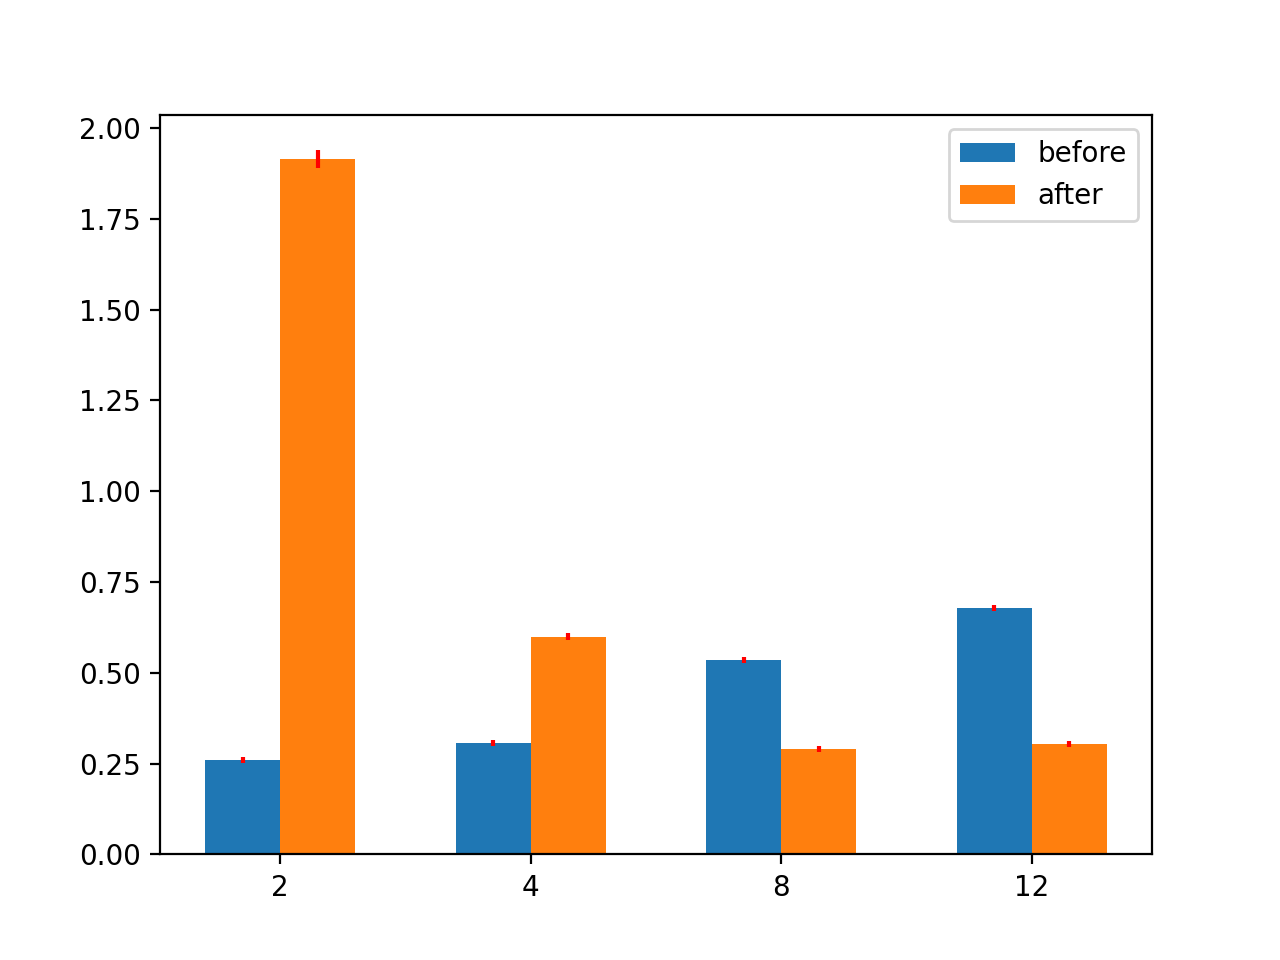

In [30]:
disparities = pd.DataFrame(columns = ["bandwidth", "before", "after", "error_before", "error_after"])
disparities["bandwidth"] = [2, 4, 8, 12]


r = retail = df_clean[(df_clean.simplified_offense_derived == "Retail Theft") & (df_clean.is_white_derived | df_clean.is_black_derived)]
#2 months before
t = temp_time_frame = r[(r.sentenceym_derived >= "2016-10") & (r.sentenceym_derived <= "2016-11")]
disparities["before"][0] = gap()
disparities["error_before"][0] = error(disparities["before"][0])

#2 months after
t = temp_time_frame = r[(r.sentenceym_derived >= "2017-01") & (r.sentenceym_derived <= "2017-02")]
disparities["after"][0] = gap()
disparities["error_after"][0] = error(disparities["after"][0])

#4 months before
t = temp_time_frame = r[(r.sentenceym_derived >= "2016-8") & (r.sentenceym_derived <= "2016-11")]
disparities["before"][1] = gap()
disparities["error_before"][1] = error(disparities["before"][1])

#4 months after
t = temp_time_frame = r[(r.sentenceym_derived >= "2017-01") & (r.sentenceym_derived <= "2017-04")]
disparities["after"][1] = gap()
disparities["error_after"][1] = error(disparities["after"][1])

#8 months before
t = temp_time_frame = r[(r.sentenceym_derived >= "2016-04") & (r.sentenceym_derived <= "2016-11")]
disparities["before"][2] = gap()
disparities["error_before"][2] = error(disparities["before"][2])

#8 months after
t = temp_time_frame = r[(r.sentenceym_derived >= "2017-01") & (r.sentenceym_derived <= "2017-09")]
disparities["after"][2] = gap()
disparities["error_after"][2] = error(disparities["after"][2])

#12 months before
t = temp_time_frame = r[(r.sentenceym_derived >= "2015-11") & (r.sentenceym_derived <= "2016-11")]
disparities["before"][3] = gap()
disparities["error_before"][3] = error(disparities["before"][3])

#12 months after
t = temp_time_frame = r[(r.sentenceym_derived >= "2017-01") & (r.sentenceym_derived <= "2018-01")]
disparities["after"][3] = gap()
disparities["error_after"][3] = error(disparities["after"][3])

print("Note a positive gap indicates a higher white incarceration rate than black incarceration rate")
disparities

width = 0.3
plt.bar(disparities.index, disparities.before, width, label = "before")
plt.bar(disparities.index + width, disparities.after, width, label = "after")
plt.xticks(disparities.index + width / 2, ('2', '4', '8', '12'))
plt.errorbar(disparities.index, disparities.before, yerr=disparities.error_before, fmt="o", color="r", markersize = 0)
plt.errorbar(disparities.index + width, disparities.after, yerr=disparities.error_after, fmt="o", color="r", markersize = 0)

plt.legend(loc='best')

### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 

In [31]:
## Interpretation
# At the beginning of the implemented policy change, the incarceration rate gap increased drastically as 
# evidenced by the severe increase in the gap in the 2 month bandwidth. But as time progressed, the policy's 
# effect was slowly mitigated as the gap lessened and eventually, the gap was less white-targeted than before.
# Those who argue the change would narrow disparities could argue that over time, the after column has been steadily 
# decreasing and with time, it has decreased below the before disparity rate as seen in the 12 month bandwidth.
# Those who argue the argue would widen disparities could argue that the lowest disparity rate recorded was a 
# before column as seen in the 2 month bandwidth. This could be used to argue that the change ultimately raised the
# disparity rates as the change was implemented when disparity rates were very low.